<a href="https://colab.research.google.com/github/simonopravil/nn_to_al-/blob/main/05_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os, random
import rasterio
import numpy as np
import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models.losses import BinaryCELoss
from rasterio.plot import show
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from random import choice, sample
from skimage.io import imread
from skimage.transform import rotate
from tensorflow.keras.utils import to_categorical

Segmentation Models: using `tf.keras` framework.


In [ ]:
def ImageDataGenerator(train_img_dir,train_mask_dir , batch_size=32,
                           rotation_range=0, horizontal_flip=False,
                           vertical_flip=False):

    while True:
        # select batch_size number of samples without replacement

        img_list = sorted(os.listdir(train_img_dir))
        msk_list = sorted(os.listdir(train_mask_dir))
        x_sub, y_sub = zip(*sample(list(zip(img_list, msk_list)), batch_size))

        # array for images
        batch_X = []
        batch_Y = []
        # loop over images of the current batch
        for idx, input_path in  enumerate(zip(x_sub, y_sub)):
            image = np.array(imread(train_img_dir+input_path[0]), dtype=float)
            mask = np.array(imread(train_mask_dir+input_path[1]), dtype=float)
            # process image
            if horizontal_flip:
                # randomly flip image up/down
                if choice([True, False]):
                    image = np.flipud(image)
                    mask = np.flipud(mask)
            if vertical_flip:
                # randomly flip image left/right
                if choice([True, False]):
                    image = np.fliplr(image)
                    mask = np.fliplr(mask)
            # rotate image by random angle between
            # -rotation_range <= angle < rotation_range
            if rotation_range != 0:
                angle = np.random.uniform(low=-abs(rotation_range),
                                          high=abs(rotation_range))
                image = rotate(image, angle, mode='reflect',
                               order=1, preserve_range=True)
                mask = rotate(mask, angle, mode='reflect',
                               order=1, preserve_range=True)
            # put all together
            batch_X += [image]
            batch_Y += [mask]
        # convert lists to np.array
        X = np.array(batch_X)
        Y = np.array(batch_Y)

        yield(X, Y)

In [ ]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed=24
batch_size= 32
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from tensorflow.keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    img = np.nan_to_num(img) #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class) #OUT
      
    return (img,mask)

In [ ]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
def Generator(train_img_dir, train_mask_dir, num_class):
    
    image_generator = ImageDataGenerator(train_img_dir,
                                         train_mask_dir , 
                                         batch_size=32,
                                         rotation_range=0, 
                                         horizontal_flip=True,
                                         vertical_flip=True)
    
    for (img, mask) in image_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/patches_splited/train_images/train/"
train_mask_path = "/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/patches_splited/train_masks/train/"
train_img_gen = Generator(train_img_path, train_mask_path, num_class=2)

val_img_path = "/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/patches_splited/val_images/val/"
val_mask_path = "/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/patches_splited/val_masks/val/"
val_img_gen = Generator(val_img_path, val_mask_path, num_class=2)

#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

In [ ]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir(train_img_path))
num_val_images = len(os.listdir(val_img_path))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=2

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights=None, 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss= tf.losses.categorical_crossentropy, metrics=[sm.metrics.iou_score, 'accuracy'])

In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

In [ ]:
def learning_curve(history, figsize=(8, 8), debug_type = 'both'):
    hist = history

    if debug_type == 'loss' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training loss', 'Validation loss'])
    if debug_type == 'iou_score' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['iou_score'])
        plt.plot(hist['val_iou_score'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training iou_score', 'Validation iou_score'])

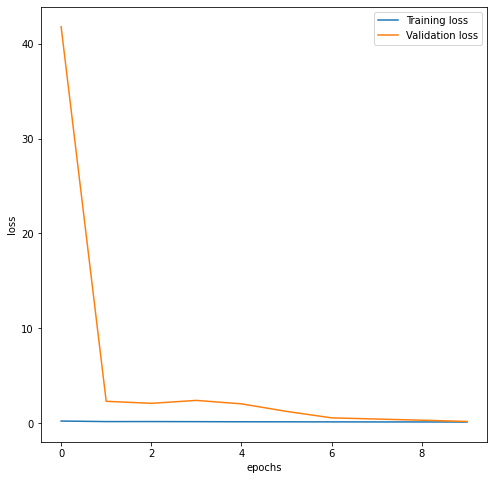

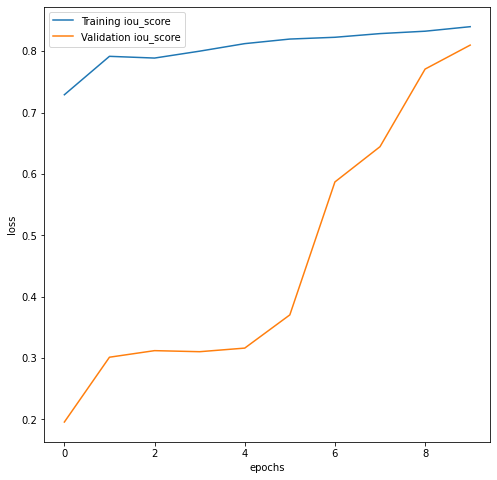

In [ ]:
learning_curve(history.history)

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
ep.plot_rgb(
    test_image_batch[img_num][...,0:3].swapaxes(0,2), 
    stretch=True,
)
#plt.imshow(test_image_batch[img_num][...,0:3])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()